<a href="https://colab.research.google.com/github/shiv78/analyticsvidhya-Identify-the-Sentiments/blob/master/analyticsvidhya_Identify_the_Sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

help resource-
1."https://towardsdatascience.com/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5"

Import lib and framework for this project

In [0]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
nltk.download("stopwords") 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# remove # for first time to downlode 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


2.get data

In [0]:
train_url="https://raw.githubusercontent.com/shiv78/analyticsvidhya-Identify-the-Sentiments/master/data/train.csv"
test_url="https://raw.githubusercontent.com/shiv78/analyticsvidhya-Identify-the-Sentiments/master/data/test.csv"

In [0]:
train=pd.read_csv(train_url)
test=pd.read_csv(test_url)


In [0]:
train.shape

(7920, 3)

In [0]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [0]:
# data in each group
train.groupby('label').count()

,id,tweet
label,,
0,5894,5894
1,2026,2026


In [0]:
# methode to remove word from sentiment
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 
  

In [0]:
# remove twitter handles (@user)
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['tweet'], "@[\w]*")


In [0]:
# remove special characters, numbers, punctuations
train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [0]:
# Removing Short Words
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [0]:
# lower the words
train['tidy_tweet']= train['tidy_tweet'].apply(lambda x: x.lower())

In [0]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: x.split())


In [0]:
train.head()

,id,label,tweet,tidy_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,"[#fingerprint, #pregnancy, test, https, mfqv, ..."
1,2,0,Finally a transparant silicon case ^^ Thanks t...,"[finally, transparant, silicon, case, thanks, ..."
2,3,0,We love this! Would you go? #talk #makememorie...,"[love, this, would, #talk, #makememories, #unp..."
3,4,0,I'm wired I know I'm George I was made that wa...,"[wired, know, george, made, that, #iphone, #cu..."
4,5,1,What amazing service! Apple won't even talk to...,"[what, amazing, service, apple, even, talk, ab..."


In [0]:

#Stemming and remove the Stopword from the train data
ps = PorterStemmer()
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: [ps.stem(word) for word in x if not word in stopwords.words('english')]) # stemming



In [0]:
train.head()

,id,label,tweet,tidy_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,"[#fingerprint, #pregnanc, test, http, mfqv, #a..."
1,2,0,Finally a transparant silicon case ^^ Thanks t...,"[final, transpar, silicon, case, thank, uncl, ..."
2,3,0,We love this! Would you go? #talk #makememorie...,"[love, would, #talk, #makememori, #unplug, #re..."
3,4,0,I'm wired I know I'm George I was made that wa...,"[wire, know, georg, made, #iphon, #cute, #dave..."
4,5,1,What amazing service! Apple won't even talk to...,"[amaz, servic, appl, even, talk, question, unl..."


In [0]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join(x))
train.head()

,id,label,tweet,tidy_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #pregnanc test http mfqv #android...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,final transpar silicon case thank uncl #yay #s...
2,3,0,We love this! Would you go? #talk #makememorie...,love would #talk #makememori #unplug #relax #i...
3,4,0,I'm wired I know I'm George I was made that wa...,wire know georg made #iphon #cute #daventri #h...
4,5,1,What amazing service! Apple won't even talk to...,amaz servic appl even talk question unless stu...


In [0]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(train['tidy_tweet'][train['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(train['tidy_tweet'][train['label'] == 1])


In [0]:
HT_regular[1:2]

[['yay', 'soni', 'xperia', 'sonyexperia']]

In [0]:

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

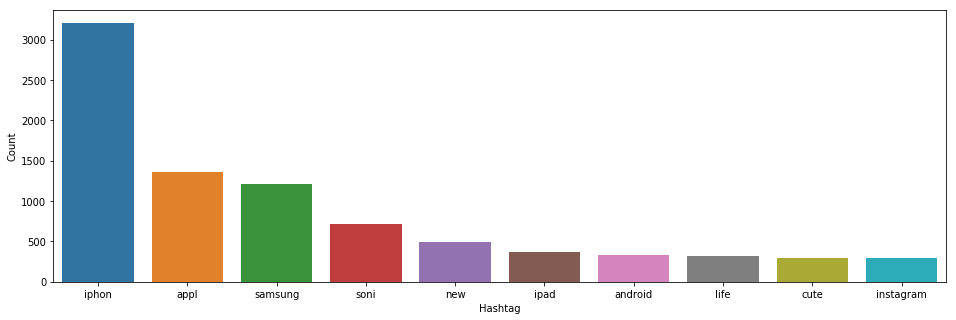

In [0]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

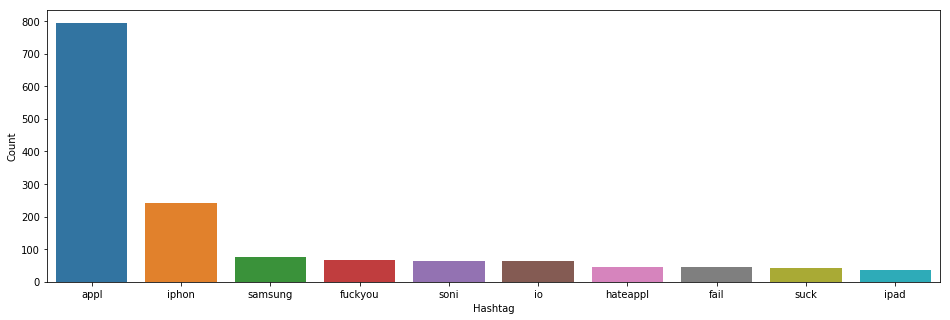

In [0]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [0]:
# Extracting Features from Cleaned Tweets


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(train['tidy_tweet'])

In [0]:
tfidf.shape

(7920, 1000)

In [0]:
# splitting data into training and validation set
train_x, test_x, train_y, test_y = train_test_split(tfidf, train['label'], random_state=42, test_size=0.3)

In [0]:
train_x.shape

(5544, 1000)

6898    0
3779    0
1611    0
4204    0
7059    0
4019    0
5935    0
2569    0
7359    0
Name: label, dtype: int64

In [0]:
# LSTM model
embed_dim = 128
lstm_out = 196
max_fatures = 1000


model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

NameError: ignored